In [1]:
%%capture
%pip install beautifulsoup4
%pip install selenium
%pip install pandas
%pip install pillow
%pip install tabulate
%pip install scikit-learn
%pip install nltk
%pip install matplotlib
%pip install wordcloud


In [2]:
%%capture
import sys
sys.setrecursionlimit(2500)

import os
import datetime
import requests
import dataclasses
from time import sleep
import warnings
warnings.simplefilter(action="ignore" , category=FutureWarning)
import numpy as np
import pandas as pd
from tabulate import tabulate
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk import PorterStemmer
from nltk.corpus import stopwords
from wordcloud import WordCloud
from selenium import webdriver
import matplotlib.pyplot as plt
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait as wait
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

Defines a Review class representing a review, with attributes score (float) and review (str)

In [88]:
@dataclasses.dataclass(eq=True, frozen=True)
class Review:
    """ Represents a review """
    score: float
    review: str

In [42]:
global_reviews = [] # Global list that will store the collected reviews

Obtaining CSV files from a directory and merging them into a single pandas DataFrame while cleaning the data by removing duplicates and dropping the index column


In [89]:
class CSVMerger:
    """ Helper class to deal with csv 'data cleaning' and merging """
    @staticmethod
    def get_files(root: str):
        all_files = os.listdir(root)
        return list(filter(lambda f: f.endswith('.csv'), all_files))

    @staticmethod
    def merge(files: list, ignore_index=True):
        df = pd.concat([pd.read_csv(file) for file in files], ignore_index=ignore_index)
        df = df.drop_duplicates(subset='review', keep='first')
        try:
            df.drop('Unnamed: 0', axis=1, inplace=True)
        except:
            pass
        return df

Takes a BeautifulSoup object representing a review, extracts the score and text content of the review, creates a Review object using the extracted values, and appends it to a global list


In [8]:
def convert_to_review(li: BeautifulSoup):
    """ Converts a BeautifulSoup object representing a review to a Review object and adds it to global_reviews list """
    score = float(li.find('div', attrs={'class': 'bui-review-score__badge'}).text) # The text represents the score of the review. It is converted to a float
    try:
        review = li.find('h3').text.rstrip().strip()
    except:
        return
    review = Review(score=score, review=review)
    global_reviews.append(review)

Opens a Chrome browser in headless mode using Selenium WebDriver and initiates crawling

In [9]:
def open_browser(initial_url):
    """ Opens a Chrome browser using Selenium WebDriver and initiates crawling """
    s = Service('/Users/idodohan/Downloads/chromedriver_mac_arm64')
    o = Options()
    o.add_argument("--headless")
    driver = webdriver.Chrome(service=s, options=o)
    driver = webdriver.Chrome()
    crawl(driver, initial_url)

Crawls through a webpage, scrapes reviews from the page, clicks on buttons to load more reviews and switch to the English language, and recursively calls itself to crawl the next page if available, until there are no more pages

In [10]:
def crawl(driver, url, loop=False):
    """ Crawls a webpage, scrapes reviews, and continues to the next page if available """

    driver.get(url)

    if loop: # If its not the inital url 
        scrape(driver.page_source)
    else:
        button = driver.find_element(By.XPATH, "//button[@data-testid='fr-read-all-reviews']")
        if button.is_displayed():
            driver.execute_script("arguments[0].click();", button)
            sleep(1)
            scrape(driver.page_source)
        button = driver.find_element(By.XPATH, "//button[@data-value='en']")
        driver.execute_script("arguments[0].click();", button)
        sleep(1)
        scrape(driver.page_source)

    try: #tries to click next page. if it succeeds it calls crawl function recursively
        next_page = driver.find_element(By.XPATH, "//a[@class='pagenext']")
        if next_page:
            crawl(driver, next_page.get_attribute('href'), loop=True)
        else:
            raise Exception()
    except:
        driver.quit()

Takes HTML source code as input, uses BeautifulSoup to parse the HTML, finds review elements based on their HTML structure and class attributes, and convert each review element into a Review object 

In [11]:
def scrape(html):
    """ Scrapes reviews from the HTML source code using BeautifulSoup """

    soup = BeautifulSoup(html, "html.parser")
    reviews = soup.find_all('li', attrs={'class': 'review_list_new_item_block'})
    for review in reviews:
        convert_to_review(review)

Runnng the scraping and crawling.
We chose to initiate open_browser with these hotels because crawling through the entire website of booking would take forver.
We looked for hotels with lots of reviews to crawl from.
After the data extraction we convert the review list to a dict list and saves it to a CSV file.

In [12]:
    def run():
        try:
            open_browser('https://www.booking.com/hotel/il/indigo-tel-aviv-diamond-exchange.html?aid=304142&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYATG4AQfIAQzYAQHoAQH4AQKIAgGoAgO4AqTh3KMGwAIB0gIkZWNkM2EwYTgtYTdlMy00NmQ5LTlmNGYtNTZkYWZmYTZiZDA22AIF4AIB&sid=87802de55797c567b04a43651afb86fc&all_sr_blocks=44620301_244369195_2_2_0;checkin=2023-06-01;checkout=2023-06-02;dest_id=-781545;dest_type=city;dist=0;group_adults=2;group_children=0;hapos=7;highlighted_blocks=44620301_244369195_2_2_0;hpos=7;matching_block_id=44620301_244369195_2_2_0;no_rooms=1;req_adults=2;req_children=0;room1=A%2CA;sb_price_type=total;sr_order=popularity;sr_pri_blocks=44620301_244369195_2_2_0__81500;srepoch=1685532846;srpvid=863e515658160203;type=total;ucfs=1&#tab-reviews')
            open_browser('https://www.booking.com/hotel/us/flamingo-casino.en-gb.html?aid=304142&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYAQ64ARfIAQzYAQHoAQH4AQ2IAgGoAgO4Av_y0aMGwAIB0gIkOWNmOTMyZmMtMGI3ZS00YmI1LTllNjEtODlhNTY3MDBmZGQ42AIG4AIB&sid=edd88cfe52b63959ef8d458bbb9ca521&all_sr_blocks=5943740_299009927_2_0_0;checkin=2023-06-05;checkout=2023-07-03;dest_id=20079110;dest_type=city;dist=0;group_adults=2;group_children=0;hapos=20;highlighted_blocks=5943740_299009927_2_0_0;hpos=20;matching_block_id=5943740_299009927_2_0_0;no_rooms=1;req_adults=2;req_children=0;room1=A%2CA;sb_price_type=total;sr_order=popularity;sr_pri_blocks=5943740_299009927_2_0_0__463125;srepoch=1685372715;srpvid=ca546a15fbcd0140;type=total;ucfs=1&#tab-reviews')
            open_browser('https://www.booking.com/hotel/gb/strandpalace.en-gb.html?aid=304142&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYAQ64ARfIAQzYAQHoAQH4AQ2IAgGoAgO4Av_y0aMGwAIB0gIkOWNmOTMyZmMtMGI3ZS00YmI1LTllNjEtODlhNTY3MDBmZGQ42AIG4AIB&sid=edd88cfe52b63959ef8d458bbb9ca521&all_sr_blocks=23080241_91912860_0_2_0;checkin=2023-06-05;checkout=2023-07-03;dest_id=2099;dest_type=landmark;dist=0;group_adults=2;group_children=0;hapos=11;highlighted_blocks=23080241_91912860_0_2_0;hpos=11;matching_block_id=23080241_91912860_0_2_0;no_rooms=1;req_adults=2;req_children=0;room1=A%2CA;sb_price_type=total;sr_order=popularity;sr_pri_blocks=23080241_91912860_0_2_0__943400;srepoch=1685368902;srpvid=6eda62a2956301ac;type=total;ucfs=1&#tab-reviews')
            open_browser('https://www.booking.com/hotel/gb/park-plaza-westminster-bridge.en-gb.html?aid=304142&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYAQ64ARfIAQzYAQHoAQH4AQ2IAgGoAgO4Av_y0aMGwAIB0gIkOWNmOTMyZmMtMGI3ZS00YmI1LTllNjEtODlhNTY3MDBmZGQ42AIG4AIB&sid=edd88cfe52b63959ef8d458bbb9ca521&all_sr_blocks=18001610_91465416_0_2_0;checkin=2023-06-05;checkout=2023-07-03;dest_id=2099;dest_type=landmark;dist=0;group_adults=2;group_children=0;hapos=16;highlighted_blocks=18001610_91465416_0_2_0;hpos=16;matching_block_id=18001610_91465416_0_2_0;no_rooms=1;req_adults=2;req_children=0;room1=A%2CA;sb_price_type=total;sr_order=popularity;sr_pri_blocks=18001610_91465416_0_2_0__1044200;srepoch=1685368902;srpvid=6eda62a2956301ac;type=total;ucfs=1&#tab-reviews')
            open_browser('https://www.booking.com/hotel/gb/zedwell-trocadero.en-gb.html?aid=304142&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYAQ64ARfIAQzYAQHoAQH4AQ2IAgGoAgO4Av_y0aMGwAIB0gIkOWNmOTMyZmMtMGI3ZS00YmI1LTllNjEtODlhNTY3MDBmZGQ42AIG4AIB&sid=edd88cfe52b63959ef8d458bbb9ca521&all_sr_blocks=569724102_217452649_2_0_0;checkin=2023-06-05;checkout=2023-07-03;dest_id=2099;dest_type=landmark;dist=0;group_adults=2;group_children=0;hapos=41;highlighted_blocks=569724102_217452649_2_0_0;hpos=16;matching_block_id=569724102_217452649_2_0_0;no_rooms=1;req_adults=2;req_children=0;room1=A%2CA;sb_price_type=total;sr_order=popularity;sr_pri_blocks=569724102_217452649_2_0_0__545100;srepoch=1685369005;srpvid=6eda62a2956301ac;type=total;ucfs=1&#tab-reviews')
            open_browser('https://www.booking.com/hotel/gb/centralparklondon.en-gb.html?aid=304142&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYAQ64ARfIAQzYAQHoAQH4AQ2IAgGoAgO4Av_y0aMGwAIB0gIkOWNmOTMyZmMtMGI3ZS00YmI1LTllNjEtODlhNTY3MDBmZGQ42AIG4AIB&sid=edd88cfe52b63959ef8d458bbb9ca521&all_sr_blocks=10276103_91909117_0_2_0;checkin=2023-06-05;checkout=2023-07-03;dest_id=2099;dest_type=landmark;dist=0;group_adults=2;group_children=0;hapos=85;highlighted_blocks=10276103_91909117_0_2_0;hpos=10;matching_block_id=10276103_91909117_0_2_0;no_rooms=1;req_adults=2;req_children=0;room1=A%2CA;sb_price_type=total;sr_order=popularity;sr_pri_blocks=10276103_91909117_0_2_0__575000;srepoch=1685369126;srpvid=6eda62a2956301ac;type=total;ucfs=1&#tab-reviews')
            open_browser('https://www.booking.com/hotel/us/harrah-s-paris.en-gb.html?aid=304142&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYAQ64ARfIAQzYAQHoAQH4AQ2IAgGoAgO4Av_y0aMGwAIB0gIkOWNmOTMyZmMtMGI3ZS00YmI1LTllNjEtODlhNTY3MDBmZGQ42AIG4AIB&sid=edd88cfe52b63959ef8d458bbb9ca521&all_sr_blocks=7598932_299009908_2_0_0;checkin=2023-06-05;checkout=2023-07-03;dest_id=20079110;dest_type=city;dist=0;group_adults=2;group_children=0;hapos=48;highlighted_blocks=7598932_299009908_2_0_0;hpos=23;matching_block_id=7598932_299009908_2_0_0;no_rooms=1;req_adults=2;req_children=0;room1=A%2CA;sb_price_type=total;sr_order=popularity;sr_pri_blocks=7598932_299009908_2_0_0__1614625;srepoch=1685372838;srpvid=ca546a15fbcd0140;type=total;ucfs=1&#tab-reviews')
            open_browser('https://www.booking.com/hotel/us/treasure-island.en-gb.html?aid=1288894&label=metagha-link-LUIL-hotel-367243_dev-desktop_los-1_bw-2_dow-Wednesday_defdate-1_room-0_gstadt-2_rateid-public_aud-0_gacid-17481781600_mcid-10_ppa-1_clrid-0_ad-1_gstkid-0_checkin-20230531_&sid=edd88cfe52b63959ef8d458bbb9ca521&all_sr_blocks=36724304_109905789_2_0_0%3Bcheckin%3D2023-05-31%3Bcheckout%3D2023-06-01%3Bdest_id%3D20079110%3Bdest_type%3Dcity%3Bdist%3D0%3Bgroup_adults%3D2%3Bgroup_children%3D0%3Bhapos%3D1%3Bhighlighted_blocks%3D36724304_109905789_2_0_0%3Bhpos%3D1%3Bmatching_block_id%3D36724304_109905789_2_0_0%3Bno_rooms%3D1%3Breq_adults%3D2%3Breq_children%3D0%3Broom1%3DA%2CA%3Bsb_price_type%3Dtotal%3Bsr_order%3Dpopularity%3Bsr_pri_blocks%3D36724304_109905789_2_0_0__5596%3Bsrepoch%3D1685373159%3Bsrpvid%3D888f6af352600216%3Btype%3Dtotal%3Bucfs%3D1&lang=en-gb&soz=1&lang_changed=1#tab-reviews')
            open_browser('https://www.booking.com/hotel/us/luxor.html?aid=1288894&label=metagha-link-LUIL-hotel-367243_dev-desktop_los-1_bw-2_dow-Wednesday_defdate-1_room-0_gstadt-2_rateid-public_aud-0_gacid-17481781600_mcid-10_ppa-1_clrid-0_ad-1_gstkid-0_checkin-20230531_&sid=edd88cfe52b63959ef8d458bbb9ca521&all_sr_blocks=18611732_260349926_2_0_0%3Bcheckin%3D2023-05-31%3Bcheckout%3D2023-06-01%3Bdest_id%3D20079110%3Bdest_type%3Dcity%3Bdist%3D0%3Bgroup_adults%3D2%3Bgroup_children%3D0%3Bhapos%3D12%3Bhighlighted_blocks%3D18611732_260349926_2_0_0%3Bhpos%3D12%3Bmatching_block_id%3D18611732_260349926_2_0_0%3Bno_rooms%3D1%3Breq_adults%3D2%3Breq_children%3D0%3Broom1%3DA%2CA%3Bsb_price_type%3Dtotal%3Bsr_order%3Dpopularity%3Bsr_pri_blocks%3D18611732_260349926_2_0_0__3280%3Bsrepoch%3D1685373215%3Bsrpvid%3D41b36b0e611102cf%3Btype%3Dtotal%3Bucfs%3D1&lang=en-us&soz=1&lang_changed=1#tab-reviews')
            open_browser('https://www.booking.com/hotel/us/pod-times-square.en-gb.html?aid=356980&label=gog235jc-1FCAIo7AE4EUgzWANoaogBAZgBMbgBB8gBDNgBAegBAfgBAogCAagCA7gC15XDowbAAgHSAiRkMTQ5MTY5Ni0zNTgwLTQwZjMtYTkxYi1kNTlmMDdlODgxMTPYAgXgAgE&sid=edd88cfe52b63959ef8d458bbb9ca521&all_sr_blocks=237726011_258445695_2_0_0&checkin=2023-06-01&checkout=2023-06-02&dest_id=20088325&dest_type=city&group_adults=2&group_children=0&hapos=3&highlighted_blocks=237726011_258445695_2_0_0&hpos=3&matching_block_id=237726011_258445695_2_0_0&no_rooms=1&req_adults=2&req_children=0&room1=A%2CA&sb_price_type=total&sr_order=popularity&sr_pri_blocks=237726011_258445695_2_0_0__15900&srepoch=1685113632&srpvid=6a126a45e7a50327&type=total&ucfs=1&#tab-reviews')
            open_browser('https://www.booking.com/hotel/gb/z-holborn.en-gb.html?aid=304142&label=gen173nr-1FCAEoggI46AdIM1gEaGqIAQGYAQ64ARfIAQzYAQHoAQH4AQ2IAgGoAgO4Av_y0aMGwAIB0gIkOWNmOTMyZmMtMGI3ZS00YmI1LTllNjEtODlhNTY3MDBmZGQ42AIG4AIB&sid=edd88cfe52b63959ef8d458bbb9ca521&all_sr_blocks=547293504_197707915_0_0_0;checkin=2023-06-05;checkout=2023-07-03;dest_id=2099;dest_type=landmark;dist=0;group_adults=2;group_children=0;hapos=67;highlighted_blocks=547293504_197707915_0_0_0;hpos=17;matching_block_id=547293504_197707915_0_0_0;no_rooms=1;req_adults=2;req_children=0;room1=A%2CA;sb_price_type=total;sr_order=popularity;sr_pri_blocks=547293504_197707915_0_0_0__610500;srepoch=1685369053;srpvid=6eda62a2956301ac;type=total;ucfs=1&#tab-reviews')
        except Exception as e:
            print(e)
        
        df = pd.DataFrame([review.__dict__ for review in list(global_reviews)])
        df.to_csv(f'reviews_{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}.csv')

        files = CSVMerger.get_files('.')
        df = CSVMerger.merge(files)
        df.to_csv(f'reviews.csv')
        print(df)

In [13]:
run()

Message: no such element: Unable to locate element: {"method":"xpath","selector":"//button[@data-testid='fr-read-all-reviews']"}
  (Session info: chrome=114.0.5735.106); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
0   chromedriver                        0x0000000102e5bf48 chromedriver + 4226888
1   chromedriver                        0x0000000102e544f4 chromedriver + 4195572
2   chromedriver                        0x0000000102a98d68 chromedriver + 281960
3   chromedriver                        0x0000000102ad3fc8 chromedriver + 524232
4   chromedriver                        0x0000000102b0ac58 chromedriver + 748632
5   chromedriver                        0x0000000102ac7f1c chromedriver + 474908
6   chromedriver                        0x0000000102ac8ef4 chromedriver + 478964
7   chromedriver                        0x0000000102e1d59c chromedriver + 3970460
8   chromedriver      

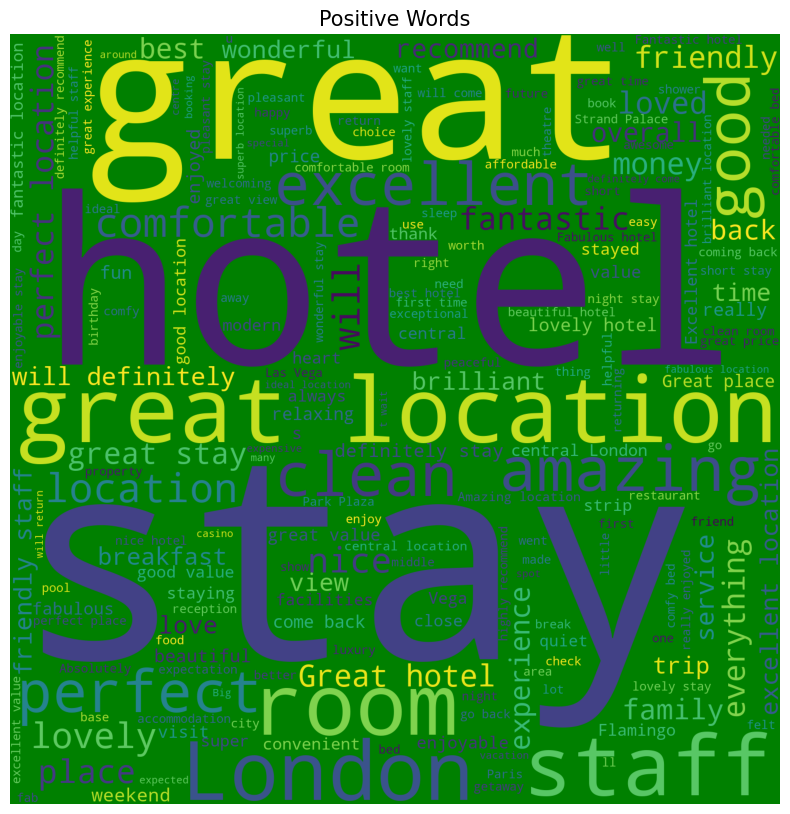

In [3]:
# Creates a word cloud of positive words (where score > 8)
reviews_df = pd.read_csv('reviews.csv')
positive = reviews_df[reviews_df['score'] > 8]
plt.rcParams['figure.figsize'] = (10,10)
plt.style.use('fast')
wc = WordCloud(background_color='green', width=1500, height=1500).generate(' '.join((positive['review'])))

plt.title('Positive Words', fontsize=15)
plt.imshow(wc)
plt.axis('off')
plt.show()

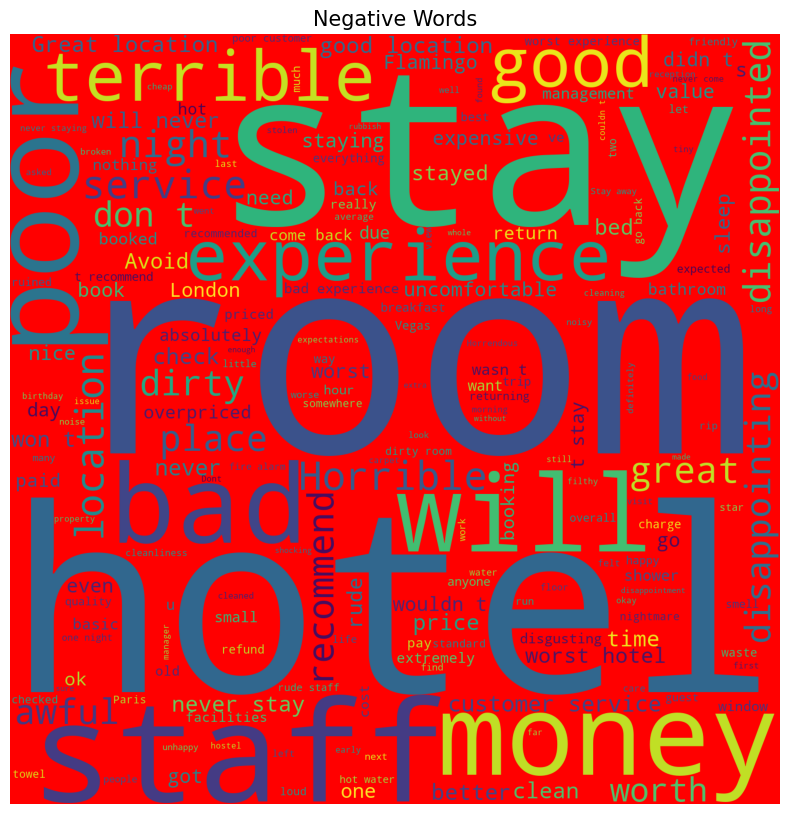

In [4]:
# Creates a word cloud of negative words (where score < 4)
negative = reviews_df[reviews_df['score'] < 4]
plt.rcParams['figure.figsize'] = (10,10)
plt.style.use('fast')
wc = WordCloud(background_color='red', width=1500, height=1500).generate(' '.join((negative['review'])))

plt.title('Negative Words', fontsize=15)
plt.imshow(wc)
plt.axis('off')
plt.show()

nan


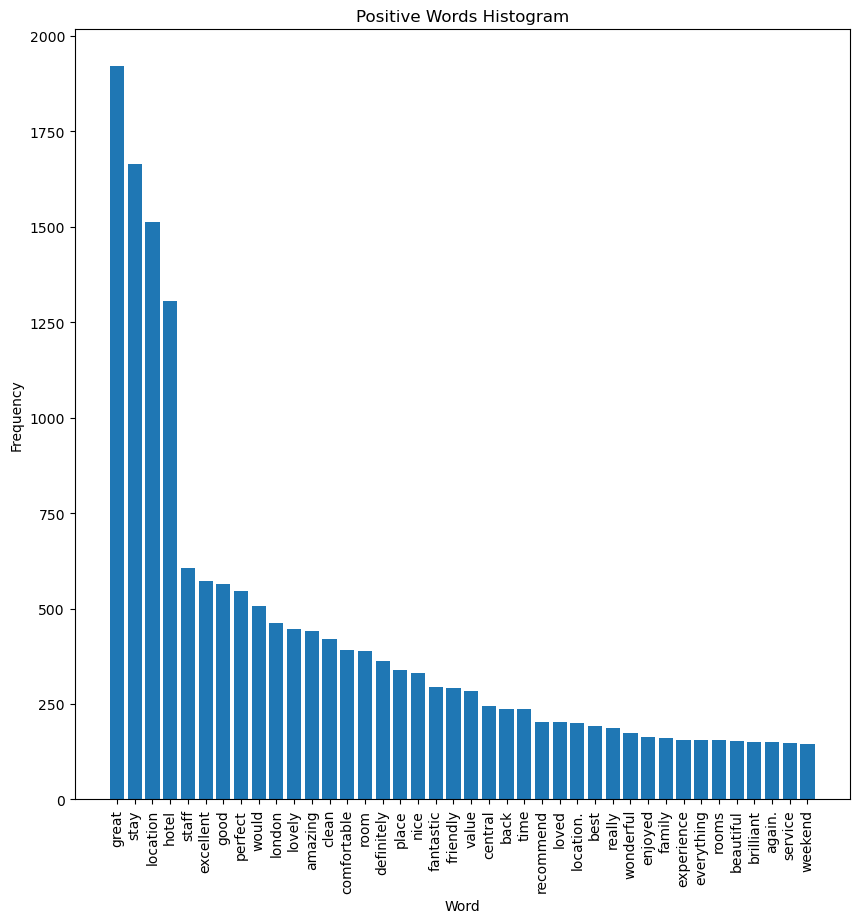

In [8]:
reviews_df = pd.read_csv('reviews.csv')
reviews_df = clean_data(reviews_df)
positive_reviews = reviews_df[reviews_df['score'] > 8]['review']
positive_text = ' '.join(positive_reviews)
words = positive_text.split()
words = [word for word in words if word not in stopwords.words('english')]
word_counts = pd.Series(words).value_counts()

word_list = word_counts.index.tolist()
count_list = word_counts.tolist()

plt.bar(word_list[0:40], count_list[0:40])

plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Positive Words Histogram")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.show()

nan


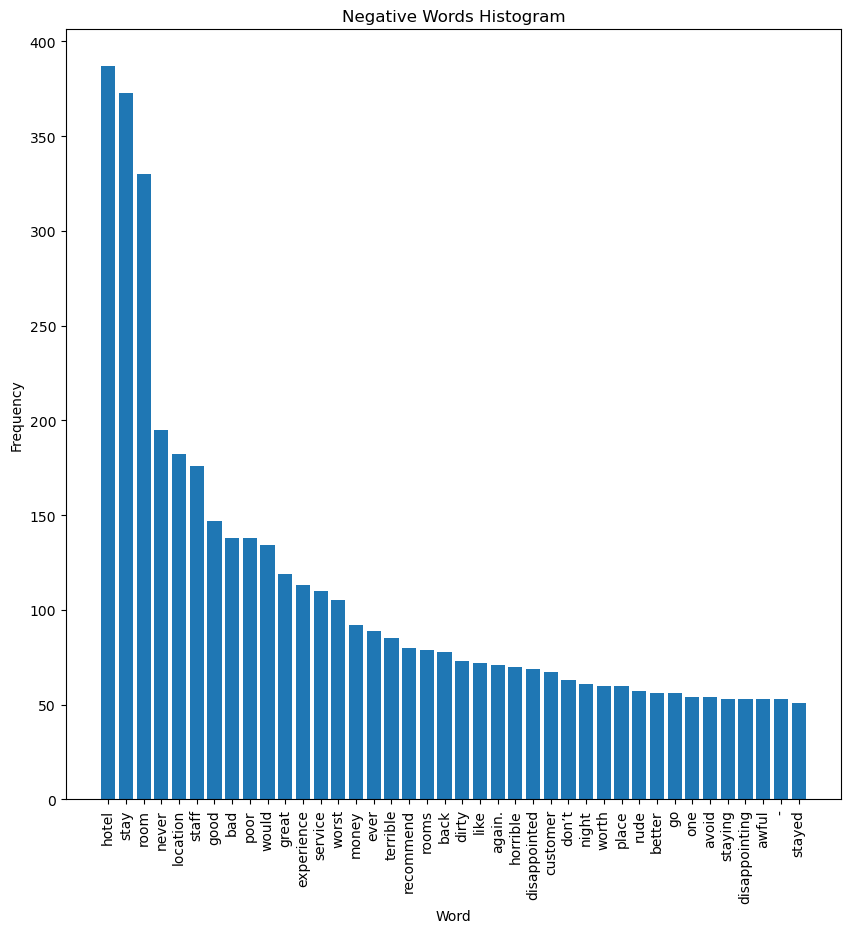

In [9]:
reviews_df = pd.read_csv('reviews.csv')
reviews_df = clean_data(reviews_df)
positive_reviews = reviews_df[reviews_df['score'] < 4]['review']
positive_text = ' '.join(positive_reviews)
words = positive_text.split()
words = [word for word in words if word not in stopwords.words('english')]
word_counts = pd.Series(words).value_counts()

word_list = word_counts.index.tolist()
count_list = word_counts.tolist()

plt.bar(word_list[0:40], count_list[0:40])

plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title("Negative Words Histogram")

# Rotate x-axis labels for better readability
plt.xticks(rotation=90)

plt.show()

In [10]:
def clean_data(df):
    for i, review in enumerate(df['review']):
        try:
            lowercase_review = review.lower()
            processed_review = lowercase_review.replace(',', '')
            df.at[i, 'review'] = processed_review
        except:
            print(review)
            continue
    return df

Reads a CSV file containing reviews and scores, extracts the reviews and scores, and returns them as separate lists

In [11]:
def get_reviews_and_scores_from_csv():
    csv = pd.read_csv('reviews.csv')
    csv = clean_data(csv)
    reviews = [review if isinstance(review, str) else "" for review in csv['review'].values]
    scores = np.array(csv['score'].values, dtype=int)
    
    return reviews, scores

In [12]:
reviews, scores = get_reviews_and_scores_from_csv()

nan


Prepares the data by converting scores to classes and text data into numerical features, then trains a Naive Bayes classifier using the prepared data, and finally returns the trained classifier and the vectorizer used for feature transformation.

In [13]:
def prepare_and_train():
    # Convert scores to classes (1 to 10)
    classes = np.array(scores)
    
    # Convert text data into numerical features
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(reviews)
    
    # Train the Naive Bayes classifier
    classifier = MultinomialNB()
    classifier.fit(X, classes)
    
    return classifier, vectorizer

In [14]:
classifier, vectorizer = prepare_and_train()

Predicts the scores for a given list of reviews by transforming them into numerical features using the vectorizer and using the trained classifier to predict the scores, and returns a list of predictions containing the original reviews and their corresponding predicted scores

In [15]:
def predict(reviews_to_predict):
    predictions = []
    for review in reviews_to_predict:
        str_review = review
        review = vectorizer.transform([review])
        predicted_score = classifier.predict(review)
        predictions.append([str_review, predicted_score])
    return predictions

Calculates the accuracy of the predictions by comparing each predicted score with the corresponding actual score, and returns the accuracy as a percentage

In [16]:
def get_accuracy(predictions, actual_scores):
    correct_predictions = 0
    total_predictions = len(predictions)

    for prediction, actual_score in zip(predictions, actual_scores):
        if (prediction < 5 and actual_score < 5) or (prediction >= 5 and actual_score >= 5):
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions
    return accuracy

Generates predictions for the given reviews, extracts the predicted scores from the predictions, calculates the accuracy by comparing the predicted scores with the actual scores, and assigns the accuracy value to the variable accuracy

In [17]:
predictions = predict(reviews)
predicted_scores = [prediction[1][0] for prediction in predictions]
accuracy = get_accuracy(predicted_scores, scores)
accuracy

0.8905263157894737

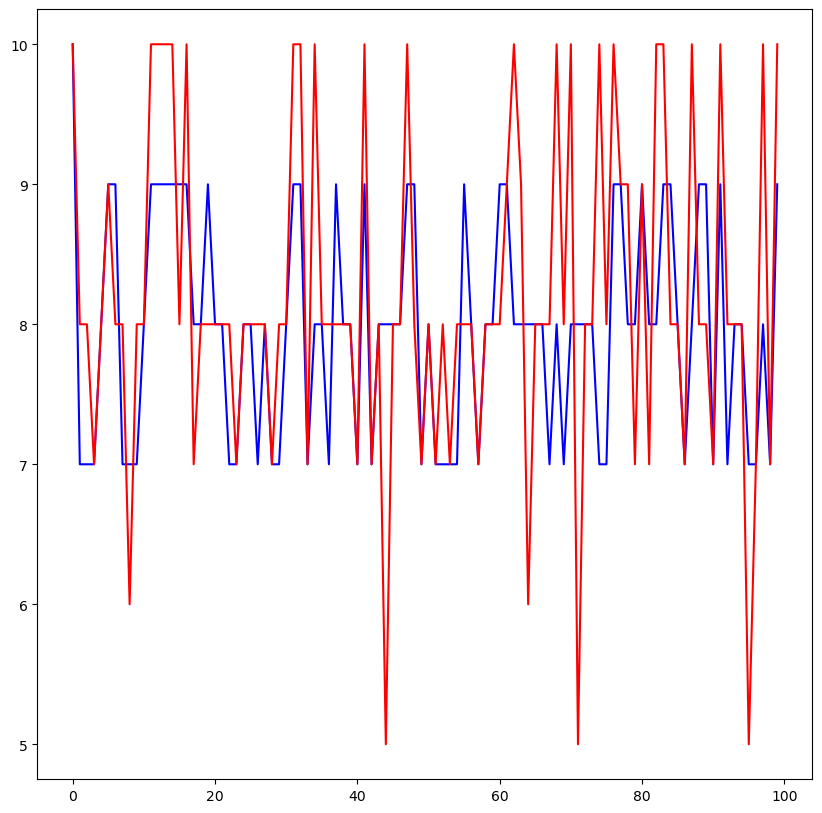

In [18]:
plt.plot(scores[0:100], 'b', predicted_scores[0:100], 'r')

Generates predictions for a list of reviews and then prints the predictions in a tabular format with the headers "Text" and "Prediction"

In [19]:
reviews_to_predict = ['good', 'was not great but im very very happy', 'what', 'poor design, good food', 'more than average', 'ido not not good', 'I am happy', 'I am bad', 'this movie should have been great but it was not good', 'not good', 'great great', 'great great great', 'great great great great', 'bad bad bad bad']
predictions = predict(reviews_to_predict)
print(tabulate(predictions, headers=['Text', 'Prediction']))

Text                                                     Prediction
-----------------------------------------------------  ------------
good                                                              8
was not great but im very very happy                              8
what                                                              8
poor design, good food                                            7
more than average                                                 6
ido not not good                                                  5
I am happy                                                        8
I am bad                                                          1
this movie should have been great but it was not good             7
not good                                                          7
great great                                                       8
great great great                                                 8
great great great great                         

Data preparation and training process by applying word stemming and ignoring stopwords to the reviews. Removes English stopwords, and then converts the cleaned reviews into numerical features. Trains a Multinomial Naive Bayes classifier on the transformed features and returns the trained classifier and vectorizer

In [20]:
def experimental_prepare_and_train():
    # Trying with word stemming and ignoring stopwords
    
    ps = PorterStemmer()
    cleaned_reviews = []
    for review in reviews:
        review = review.split()
        review = [ps.stem(word) for word in review if not word in set(stopwords.words('english'))]
        review = ' '.join(review)
        cleaned_reviews.append(review)

    classes = np.array(scores)
    vectorizer = CountVectorizer(stop_words='english')
    X = vectorizer.fit_transform(cleaned_reviews)
    classifier = MultinomialNB()
    classifier.fit(X, classes)
    
    return classifier, vectorizer

In [21]:
classifier, vectorizer = experimental_prepare_and_train()

Test to see if the experimental_prepare_and_train improves the accuracy
verdict = NO!!!! :(

In [22]:
predictions = predict(reviews)
predicted_scores = [prediction[1] for prediction in predictions]
accuracy = get_accuracy(predicted_scores, scores)
accuracy

0.8674141876430206

In [23]:
reviews_to_predict = ['good', 'was not great but im very very happy', 'what', 'poor design, good food', 'more than average', 'ido not not good', 'I am happy', 'I am bad', 'this movie should have been great but it was not good', 'not good', 'great great', 'great great great', 'great great great great', 'bad bad bad bad']
predictions = predict(reviews_to_predict)
print(tabulate(predictions, headers=['Text', 'Prediction']))

Text                                                     Prediction
-----------------------------------------------------  ------------
good                                                              8
was not great but im very very happy                              8
what                                                             10
poor design, good food                                            7
more than average                                                 5
ido not not good                                                  8
I am happy                                                       10
I am bad                                                          1
this movie should have been great but it was not good             8
not good                                                          8
great great                                                       8
great great great                                                 8
great great great great                         